In [1]:
import os 

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np
model = SentenceTransformer("all-MiniLM-L6-v2")

def fastLexRank(df: pd.DataFrame) -> pd.DataFrame:
    posts = df["post"]
    #remove @mentions
    posts = posts.str.replace(r'@\w+', '', regex=True)
    #remove hashtags
    posts = posts.str.replace(r'#\w+', '', regex=True)
    #remove urls
    posts = posts.str.replace(r'http\S+', '', regex=True)
    embeddings = model.encode(posts, show_progress_bar=True)
    # sum in column
    z = embeddings.sum(axis=0)
    # normalize the sum
    z = z / np.sqrt((z**2).sum(axis=0))
    ap = np.dot(embeddings, z)
    # normalize the scores by its sum
    df["ap"] = ap
    df.sort_values(by="ap")
    return df

NameError: name 'pd' is not defined

In [1]:
import json

with open(file="../../echo-chamber/data/mastodon.trump.json") as f:
    data = json.load(f)

In [ ]:
import re
from bs4 import BeautifulSoup
from fast_langdetect import detect_language
md = []
for post in data:
    if not post["in_reply_to_id"]:
        reply = False
    else:
        reply = True
    content = post["content"]
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")

    # Remove all 'a' tags entirely
    for a_tag in soup.find_all("a"):
        a_tag.unwrap()

    # Get the plain text
    plain_text = soup.get_text(separator=" ")

    # Regular expression to match and remove URLs
    cleaned_content = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|\s)+",
        "",
        plain_text,
    )

    # Remove excess spaces left by removing the link
    cleaned_content = re.sub(r"\s+", " ", cleaned_content).strip()
    lang = detect_language(cleaned_content)
    if cleaned_content:
        md.append([post["id"], cleaned_content, lang, reply, post.get("in_reply_to_id", None),])

In [3]:
import pandas as pd

md_df = pd.DataFrame(md, columns=["id", "post", "lang", "reply", "in_reply_to_id"])


In [4]:
import networkx as nx

md_graph = nx.DiGraph()
md_edge_list = md_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph

# Add edges, skipping any with None as parent
for child, parent in md_edge_list:
    if parent is not None:
        md_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        md_graph.add_node(child)



In [59]:
md_df = fastLexRank(md_df)

Batches: 100%|██████████| 3457/3457 [00:38<00:00, 90.35it/s] 


In [73]:
md_df.sort_values(by='ap',ascending=False)[:20].to_csv("md_top20.csv")

In [ ]:
data[0]

In [5]:
import json

with open(file="../../echo-chamber/data/bsky.trump.json") as f:
    bsky = json.load(f)


In [6]:
bsky_data = []
from fast_langdetect import detect_language

for post in bsky:
    if not post["record"].get("reply", None):
        reply = False
    else:
        reply = True
    if post["record"].get("text", None):
        language = post["record"].get("langs", None)
        language = language[0] if language else None
        if not language:
            language = detect_language(
                post["record"]["text"].replace("\n", " ")
            ).lower()
        bsky_data.append([post["_id"], post["record"]["text"], language, reply, post["record"].get("reply", {}).get("parent", {}).get('uri',None),])

In [7]:
import pandas as pd

bsky_df = pd.DataFrame(bsky_data, columns=["id", "post", "lang", "reply", "in_reply_to_id"])

In [8]:
bsky_graph = nx.DiGraph()
bsky_edge_list = bsky_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph

# Add edges, skipping any with None as parent
for child, parent in bsky_edge_list:
    if parent is not None:
        bsky_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        bsky_graph.add_node(child)


In [92]:
bsky_graph.number_of_edges()

1681503

In [62]:
bsky_df = fastLexRank(bsky_df)

Batches: 100%|██████████| 73985/73985 [12:35<00:00, 97.90it/s] 


In [72]:
bsky_df.sort_values(by='ap',ascending=False)[:20].to_csv("bsky_top20.csv")

In [39]:
bsky_df.reply.value_counts()

reply
True     1681503
False     686010
Name: count, dtype: int64

In [6]:
bsky_df["lang"].value_counts()[:10]

In [9]:
bsky_df["lang"].value_counts()

lang
en     1299573
de      741698
ja      122146
fr       38315
sv       24420
        ...   
tt           1
kk           1
jbo          1
ur           1
sw           1
Name: count, Length: 122, dtype: int64

In [7]:
bsky_df["post"].nunique()

In [2]:
import json

with open(file="../../echo-chamber/data/truthsocial.trump.json") as f:
    ts = json.load(f)


In [ ]:
import re
from bs4 import BeautifulSoup

ts_data = []
for post in ts:
    if post["in_reply_to_id"] or post["quote_id"]:
        reply = True
    else:
        reply = False
    content = post["content"]
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")

    # Remove all 'a' tags entirely
    for a_tag in soup.find_all("a"):
        a_tag.unwrap()

    # Get the plain text
    plain_text = soup.get_text(separator=" ")

    # Regular expression to match and remove URLs
    cleaned_content = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|\s)+",
        "",
        plain_text,
    )

    # Remove excess spaces left by removing the link
    cleaned_content = re.sub(r"\s+", " ", cleaned_content).strip()
    lang = detect_language(cleaned_content.replace("\n", " ").lower()).lower()
    if cleaned_content:
        ts_data.append([post["id"], cleaned_content, lang, reply, post.get("in_reply_to_id", None),])

In [ ]:
ts_df = pd.DataFrame(ts_data, columns=["id", "post", 'lang', 'reply', 'in_reply_to_id'])

In [12]:
ts_graph = nx.DiGraph()
ts_edge_list = ts_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph
# Add edges, skipping any with None as parent
for child, parent in ts_edge_list:
    if parent is not None:
        ts_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        ts_graph.add_node(child)
ts_graph.number_of_edges()

3119722

In [40]:
ts_df.reply.value_counts()

reply
True     3126222
False      52129
Name: count, dtype: int64

In [41]:
ts_df.lang.value_counts()

lang
en     3023322
it       26964
de       18225
es       10194
ru        9397
        ...   
mwl          1
lrc          1
vec          1
mai          1
pam          1
Name: count, Length: 165, dtype: int64

In [ ]:
ts_df = fastLexRank(ts_df)

Batches: 100%|██████████| 99324/99324 [08:41<00:00, 190.30it/s]


In [71]:
ts_df.sort_values(by='ap',ascending=False)[:20].to_csv("ts_lexrank.csv")

In [ ]:
ts_df.sort_values(by='ap',ascending=False)

In [5]:
import pandas as pd
# Reload original full post columns directly from CSV files
ts_df = pd.read_csv("ts_lexrank.csv")
bsky_df = pd.read_csv("bsky_top20.csv")
md_df = pd.read_csv("md_top20.csv")

# Add platform labels
ts_df["Platform"] = "TruthSocial"
bsky_df["Platform"] = "Bluesky"
md_df["Platform"] = "Mastodon"

# Concatenate full original posts
full_posts_df = pd.concat([
    ts_df[["Platform", "post"]],
    bsky_df[["Platform", "post"]],
    md_df[["Platform", "post"]]
], axis=1,ignore_index=True)

# Rename for LaTeX export
#full_posts_df = full_posts_df.rename(columns={"post": "Post"})

# Generate full LaTeX table with no truncation
full_latex_content = full_posts_df.to_latex(
    index=False,
    escape=True,
    longtable=True,
    column_format=r">{\raggedright\arraybackslash}p{2.5cm} >{\raggedright\arraybackslash}p{13cm}"
)


In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Step 1: Initialize the SBERT model
model = SentenceTransformer(
    "all-MiniLM-L6-v2",
)  # You can use other SBERT models as well

# Step 2: Define your two lists
list_bsky = list(bsky_df.loc[bsky_df['reply']==False, "post"])
list_ts = list(ts_df.loc[ts_df["reply"]==False, "post"])
list_md = list(md_df.loc[md_df["reply"]==False, "post"])
# Step 3: Compute embeddings for both lists
embeddings_bsky = model.encode(
    list_bsky, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)
embeddings_ts = model.encode(
    list_ts, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)

embeddings_md = model.encode(
    list_md, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)


Batches: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


In [16]:
# Step 4: Compute cosine similarity
sim_tb = util.pytorch_cos_sim(embeddings_ts.cpu(), embeddings_bsky.cpu())
sim_tm = util.pytorch_cos_sim(embeddings_ts.cpu(), embeddings_md.cpu())
sim_bm = util.pytorch_cos_sim(embeddings_bsky.cpu(), embeddings_md.cpu())


In [17]:

import networkx as nx
threshold = 0.7  # similarity threshold

# Offset functions to avoid index collisions
offset_bsky = len(embeddings_ts)
offset_masto = len(embeddings_ts) + len(embeddings_bsky)

# Helper to add weighted edges from sparse matrix
def add_edges_from_sim(sim_matrix, offset_a, offset_b):
    row, col = np.where(sim_matrix > threshold)
    weights = sim_matrix[row, col]
    edges = [
        (offset_a + i, offset_b + j, {"weight": float(w)})
        for i, j, w in zip(row, col, weights)
    ]
    return edges

# Build graph
G = nx.Graph()

# Add nodes with platform labels
G.add_nodes_from(range(len(embeddings_ts)), platform="truth")
G.add_nodes_from(
    range(offset_bsky, offset_bsky + len(embeddings_bsky)), platform="bluesky"
)
G.add_nodes_from(
    range(offset_masto, offset_masto + len(embeddings_md)), platform="mastodon"
)

# Add edges from all pairwise similarities
G.add_edges_from(add_edges_from_sim(sim_tb, 0, offset_bsky))
G.add_edges_from(add_edges_from_sim(sim_tm, 0, offset_masto))
G.add_edges_from(add_edges_from_sim(sim_bm, offset_bsky, offset_masto))

print(f"Tripartite graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Tripartite graph has 772143 nodes and 1137940 edges.


In [19]:
# Define your platform post lists
truth_posts = list_ts
bluesky_posts = list_bsky
mastodon_posts = list_md

# Compute offsets
offset_bsky = len(truth_posts)
offset_masto = len(truth_posts) + len(bluesky_posts)
components = list(nx.connected_components(G))
# find component larger than 1
components = [c for c in components if len(c) > 1]
component_posts = []

for component in components:
    posts = {
        "truth": [],
        "bluesky": [],
        "mastodon": [],
    }

    for node in component:
        if node < offset_bsky:
            posts["truth"].append(truth_posts[node])
        elif offset_bsky <= node < offset_masto:
            posts["bluesky"].append(bluesky_posts[node - offset_bsky])
        else:
            posts["mastodon"].append(mastodon_posts[node - offset_masto])

    component_posts.append(posts)


In [50]:
#writing to jsonl
import json
with open("tri_graph.jsonl", "w") as f:
    for component in component_posts:
        json.dump(component, f)
        f.write("\n")

In [24]:
import pandas as pd

component_posts_df = pd.DataFrame(component_posts)

In [38]:
component_posts_df = component_posts_df.map(lambda x: np.nan if len(x)==0 else x)
component_posts_df.dropna(how="any", inplace=True)

In [44]:
component_posts_df.to_json("triad_posts.jsonl", orient="records", lines=True)

In [1]:
import pandas as pd
component_posts_df = pd.read_json("triad_posts_annoted.jsonl", orient="records", lines=True)

    


In [ ]:
component_posts_df

In [ ]:
import pandas as pd
import json
import re
df = component_posts_df.copy().dropna(how="any")
# Function to clean and parse the response JSON string
def parse_json_block(text):
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

# Function to process the 'response' column (which contains the list of platform responses)
def extract_platform_fields(response_list):
    result = {}
    if not response_list:
        return np.nan
    for item in response_list:
        platform = item.get('platform')
        raw_response = item.get('response', '')
        try:
            parsed = parse_json_block(raw_response)
            for key, value in parsed.items():
                # Optional: normalize keys (e.g., replace spaces with underscores)
                safe_key = key.replace(" ", "_")
                result[f"{platform}_{safe_key}"] = value
        except Exception as e:
            print(f"Error parsing JSON for platform '{platform}': {e}")
            continue
    return pd.Series(result)

# Apply it to your DataFrame (replace `df` with your actual variable)
platform_fields = df['response'].apply(extract_platform_fields)

# Combine the extracted fields back into the DataFrame
df_final = pd.concat([df, platform_fields], axis=1)

# Done!
print(df_final.head())


In [ ]:
df_final

In [ ]:
from transformers import pipeline
import torch
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
pipe = pipeline(
    "text-generation",
    model="google/gemma-3-12b-it",
    device="cuda",
    torch_dtype=torch.bfloat16
)

In [ ]:

post_text = '.'.join(component_posts_df.iloc[1]["truth"])
prompt = f"""
You are a political discourse analyst.

Classify the following social media post based on:

1. Narrative Frame (e.g., corruption, persecution, legal justice, media bias, systemic inequality, etc.)
2. Main Subject (e.g., Trump, Biden, etc.)
3. Stance toward main subject (e.g., supportive, critical, neutral, unclear)
4. Topic Focus (e.g., legal, cultural, institutional, personal attack)

Return in JSON format.

Post:
\"\"\"{post_text}\"\"\"
"""

messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content":  prompt
    },
]

output = pipe(messages, max_new_tokens=200)
print(output[0]["generated_text"][-1]["content"])
# Okay, let's take a look! 
# Based on the image, the animal on the candy is a **turtle**. 
# You can see the shell shape and the head and legs.


In [ ]:
#loop throught the components
from tqdm.auto import tqdm
#response = []
for i, component in tqdm(enumerate(component_posts_df.to_dict(orient="records"))):
    print(f"Component {i+1}")
    if i != 221:
        continue
    current_response = []
    for platform, posts in component.items():
        if len(posts) > 10:
            continue

        post = ".".join(posts)
        prompt = f"""
            You are a political discourse analyst.

            Classify the following social media post based on:

            1. Narrative Frame (e.g., corruption, persecution, legal justice, media bias, systemic inequality, etc.)
            2. Main Subject (e.g., Trump, Biden, etc.)
            3. Stance toward main subject (e.g., supportive, critical, neutral, unclear)
            4. Topic Focus (e.g., legal, cultural, institutional, personal attack)

            Return in JSON format.

            Post:
            \"\"\"{post}\"\"\"
            """

        messages = [
                {
                    "role": "system",
                    "content": "You are a helpful assistant."
                },
                {
                    "role": "user",
                    "content":  prompt
                },
            ]

        output = pipe(messages, max_new_tokens=200)
        current_response.append({"platform": platform, "response": output[0]["generated_text"][-1]["content"]})
    response.insert(i, current_response)
    
        

In [ ]:
df_final.columns

/tmp/ipykernel_726452/2682651831.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_final[['truth_Stance_toward_main_subject', 'bluesky_Stance_toward_main_subject', "mastodon_Stance_toward_main_subject"]].applymap(clean_stance)
/tmp/ipykernel_726452/2682651831.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_matrix = df_transposed.applymap(lambda x: color_map.get(x, '#dddddd'))


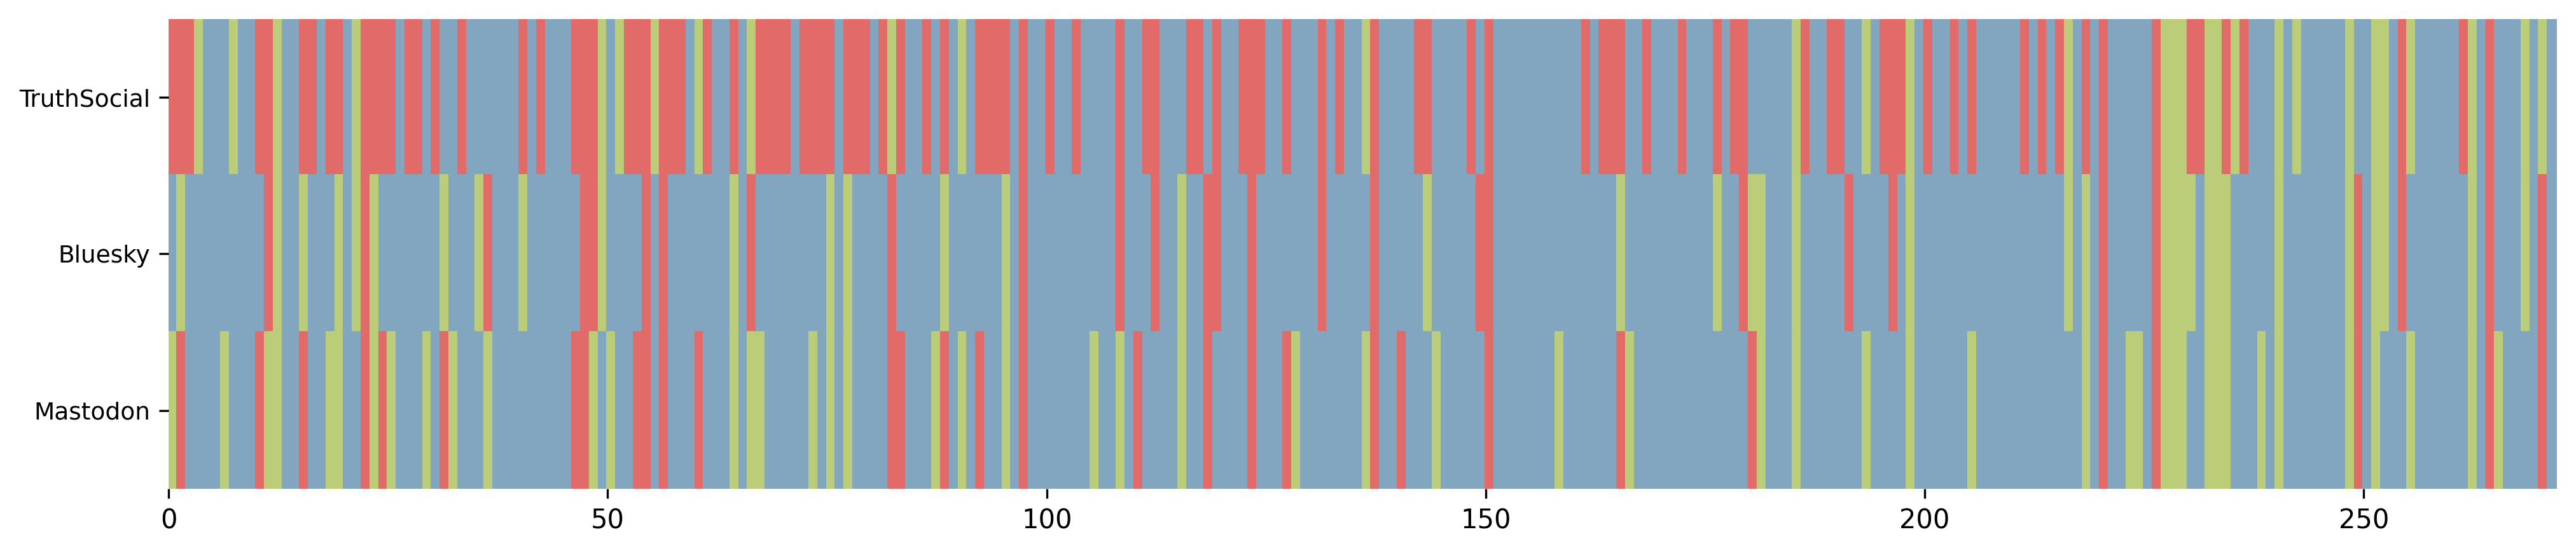

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def clean_stance(value):
    value = str(value).lower()
    if 'critical' in value:
        return 'critical'
    elif 'supportive' in value:
        return 'supportive'
    elif 'neutral' in value:
        return 'neutral'
    else:
        return 'neutral'  # optional fallback

# Apply to your DataFrame (excluding the record_id)
df_cleaned = df_final[['truth_Stance_toward_main_subject', 'bluesky_Stance_toward_main_subject', "mastodon_Stance_toward_main_subject"]].applymap(clean_stance)


# Create a color map
color_map = {
    'critical': '#82a6c0',
    'neutral': '#bbcd78',
    'supportive': '#e26a69',
    'unknown': '#dddddd'  # fallback color
}

# Create color matrix
# Transpose so platforms are rows, records are columns
df_transposed = df_cleaned.T

# Color map
color_map = {
    'critical': '#82a6c0',
    'neutral': '#bbcd78',
    'supportive': '#e26a69',
    'unknown': '#dddddd'
}
color_matrix = df_transposed.applymap(lambda x: color_map.get(x, '#dddddd'))
# Plot
fig, ax = plt.subplots(figsize=(len(df_transposed.columns) * 0.05, 3), dpi=300)  # 🔄 Wide, short
for i in range(len(df_transposed)):
    for j in range(len(df_transposed.columns)):
        ax.add_patch(plt.Rectangle((j, i), 1, 5, color=color_matrix.iat[i, j]))

# Style
y_ticks_label = ['TruthSocial', 'Bluesky', 'Mastodon']

ax.set_xlim(0, len(df_transposed.columns))
ax.set_ylim(0, len(df_transposed))
#ax.set_xticks([])
ax.set_yticks([i + 0.5 for i in range(len(df_transposed.index))])
ax.set_yticklabels(y_ticks_label, fontsize=9)
ax.invert_yaxis()
#ax.set_aspect('equal')
plt.box(False)
#plt.title('Stance Heatmap', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
component_posts_df = df_final

In [16]:
from tqdm import tqdm
truth_posts = []
bluesky_posts = []
mastodon_posts = []
truth_posts_to_matched_ids = {}
bluesky_posts_to_matched_ids = {}
mastodon_posts_to_matched_ids = {}
for i, component in tqdm(enumerate(component_posts_df.to_dict(orient="records"))):
    truth_posts.extend(component["truth"])
    truth_posts_to_matched_id = { post:i for post in component["truth"]}
    truth_posts_to_matched_ids.update(truth_posts_to_matched_id)
    bluesky_posts.extend(component["bluesky"])
    bluesky_posts_to_matched_id = {post:i for post in component["bluesky"]}
    bluesky_posts_to_matched_ids.update(bluesky_posts_to_matched_id)
    mastodon_posts.extend(component["mastodon"])
    mastodon_posts_to_matched_id = {post:i for post in component["mastodon"]}
    mastodon_posts_to_matched_ids.update(mastodon_posts_to_matched_id)
    

272it [00:00, 331065.20it/s]


In [17]:
truth_posts_post_to_id = ts_df.set_index("post")["id"].to_dict()
bluesky_posts_post_to_id = bsky_df.set_index("post")["id"].to_dict()
mastodon_posts_post_to_id = md_df.set_index("post")["id"].to_dict()

In [18]:
truth_posts_id = []
for post in truth_posts:
    truth_posts_id.append(truth_posts_post_to_id[post])
bluesky_posts_id = []
for post in bluesky_posts:
    bluesky_posts_id.append(bluesky_posts_post_to_id[post])
mastodon_posts_id = []
for post in mastodon_posts:
    mastodon_posts_id.append(mastodon_posts_post_to_id[post])


In [19]:
len(truth_posts_id)

588

In [20]:
#fetch trees of truth posts id

#all the descendants of the post
ts_trees = {}
for root in truth_posts_id:
    descendants = nx.descendants(ts_graph, root)
    tree_nodes = {root} | descendants
    ts_trees[root] = ts_graph.subgraph(tree_nodes).copy()

#fetch trees of bsky posts id
bsky_trees = {}
for root in bluesky_posts_id:
    descendants = nx.descendants(bsky_graph, root)
    tree_nodes = {root} | descendants
    bsky_trees[root] = bsky_graph.subgraph(tree_nodes).copy()
#fetch trees of mastodon posts id
mastodon_trees = {}
for root in mastodon_posts_id:
    descendants = nx.descendants(md_graph, root)
    tree_nodes = {root} | descendants
    mastodon_trees[root] = md_graph.subgraph(tree_nodes).copy()


In [21]:
# tree statistis: depth, breadth, number of nodes

def tree_statistics(tree):
    # Calculate depth (longest path from root to leaf)
    depth = nx.dag_longest_path_length(tree)
    
    # Get the root (assuming it's the first node with in-degree 0)
    roots = [n for n in tree.nodes() if tree.in_degree(n) == 0]
    if not roots:
        raise ValueError("Tree has no root (in-degree 0 node).")
    root = roots[0]
    
    # Compute levels from root
    levels = nx.single_source_shortest_path_length(tree, root)
    
    # Count how many nodes at each level
    level_counts = {}
    for level in levels.values():
        level_counts[level] = level_counts.get(level, 0) + 1
    
    # Breadth is the max number of nodes at the same level
    breadth = max(level_counts.values())
    
    # Total number of nodes
    num_nodes = tree.number_of_nodes()
    
    return depth, breadth, num_nodes

ts_stats = {}
for root, tree in ts_trees.items():
    if tree.number_of_nodes() == 0:
        ts_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    ts_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }
bsky_stats = {}
for root, tree in bsky_trees.items():
    if tree.number_of_nodes() == 0:
        bsky_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    bsky_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }
mastodon_stats = {}
for root, tree in mastodon_trees.items():
    if tree.number_of_nodes() == 0:
        mastodon_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    mastodon_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }

In [22]:
ts_stats_df = pd.DataFrame.from_dict(ts_stats, orient="index")
ts_stats_df["platform"] = "truth"
ts_stats_df["post_id"] = ts_stats_df.index
ts_stats_df.reset_index(drop=True, inplace=True)
ts_stats_df.rename(columns={"index": "post_id"}, inplace=True)
bsky_stats_df = pd.DataFrame.from_dict(bsky_stats, orient="index")
bsky_stats_df["platform"] = "bluesky"
bsky_stats_df["post_id"] = bsky_stats_df.index
bsky_stats_df.reset_index(drop=True, inplace=True)
bsky_stats_df.rename(columns={"index": "post_id"}, inplace=True)
mastodon_stats_df = pd.DataFrame.from_dict(mastodon_stats, orient="index")
mastodon_stats_df["platform"] = "mastodon"
mastodon_stats_df["post_id"] = mastodon_stats_df.index
mastodon_stats_df.reset_index(drop=True, inplace=True)
mastodon_stats_df.rename(columns={"index": "post_id"}, inplace=True)
# Concatenate all stats

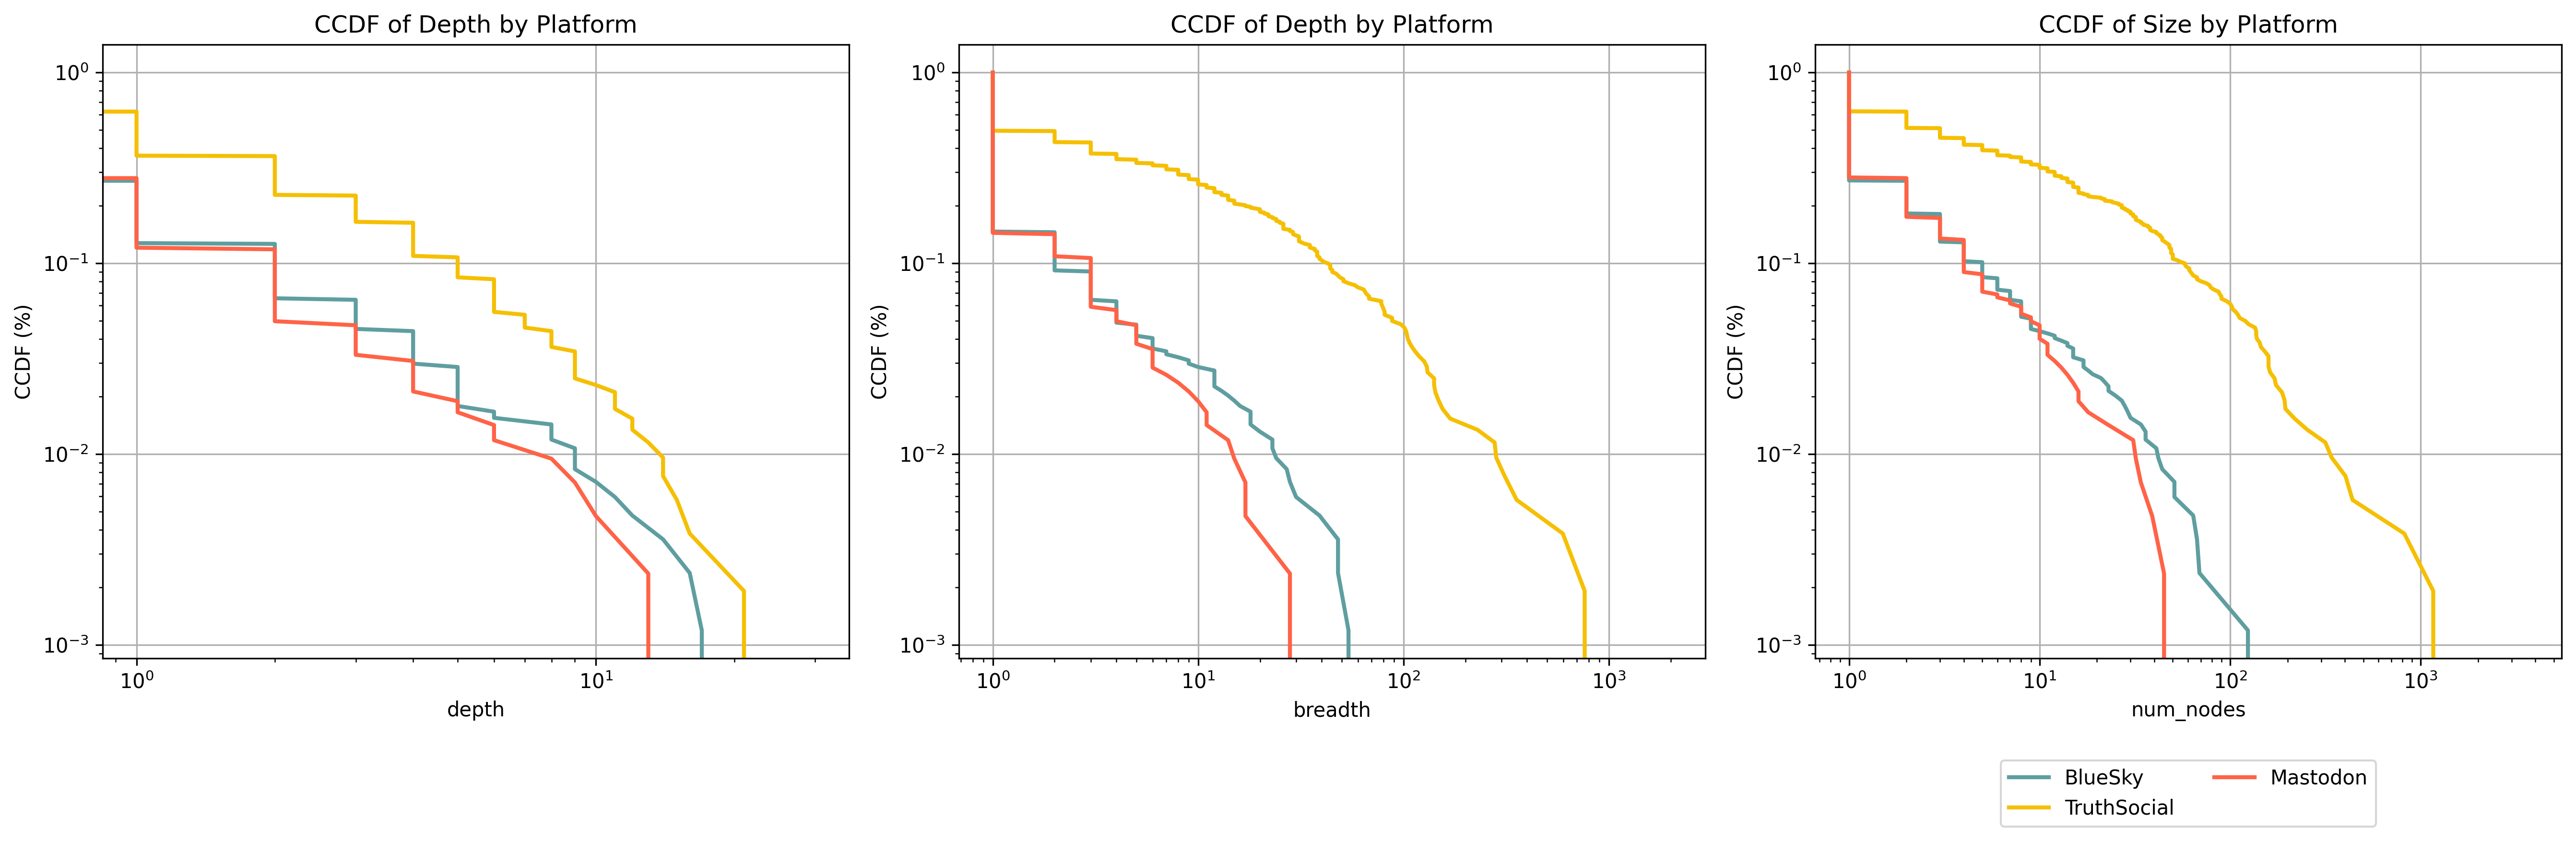

In [23]:
#plot the ccdf of the trees
import matplotlib.pyplot as plt
import numpy as np
metrics = ["depth", "breadth", "num_nodes"]
# Concatenate all stats
df = pd.concat([ts_stats_df, bsky_stats_df, mastodon_stats_df], ignore_index=True)
# Define Azure and Gold colors
colors = {"bluesky": "#5F9EA0", "truth": "#F5BF03", "mastodon": "#FF6347"}  

# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)  # 1 row, 4 columns

for idx, metric in enumerate(metrics):
    for platform in ["bluesky", "truth", 'mastodon']:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform.capitalize()}",
                       linewidth=2, color=colors[platform])
    if metric == "depth":
        metric_str = "Depth"
    elif metric == "num_nodes":
        metric_str = "Size"
    elif metric_str == "breadth":
        metric = "Breadth"
    elif metric == "structural_virality":
        metric_str = "Structural Virality"

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric_str} by Platform")
    axes[idx].grid()



plt.legend(
    labels=["BlueSky", "TruthSocial", "Mastodon"],
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

In [24]:
ts_stats_df['post'] = ts_stats_df['post_id'].map(ts_df.set_index('id')['post'])
bsky_stats_df['post'] = bsky_stats_df['post_id'].map(bsky_df.set_index('id')['post'])
mastodon_stats_df['post'] = mastodon_stats_df['post_id'].map(md_df.set_index('id')['post'])

In [25]:
ts_stats_df['matched_id'] = ts_stats_df['post'].map(truth_posts_to_matched_ids)
bsky_stats_df['matched_id'] = bsky_stats_df['post'].map(bluesky_posts_to_matched_ids)
mastodon_stats_df['matched_id'] = mastodon_stats_df['post'].map(mastodon_posts_to_matched_ids)


In [ ]:
ts_stats_df.loc[ts_stats_df['matched_id']==0,]

In [ ]:
bsky_stats_df.loc[bsky_stats_df['matched_id'] == 0, ]

In [28]:
mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 0, ]

,depth,breadth,num_nodes,platform,post_id,post,matched_id
0,0,1,1,mastodon,112597799705588821,"“Influential figures in Donald Trump’s orbit, ...",0


In [ ]:
bsky_stats_df.loc[bsky_stats_df['matched_id'] == 170, ] 

In [ ]:
ts_stats_df.loc[ts_stats_df['matched_id'] == 170, ]

In [31]:
mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 170, ]

,depth,breadth,num_nodes,platform,post_id,post,matched_id
275,3,6,10,mastodon,112633886021231318,The doctor who leaked HIPAA-protected info abo...,170


In [32]:
ts_anchor_ids = ts_stats_df.loc[ts_stats_df['matched_id'] == 0,'post_id'].values
ts_anchor_bsky_ids = bsky_stats_df.loc[bsky_stats_df['matched_id'] == 0,'post_id'].values
ts_anchor_mastodon_ids = mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 0,'post_id'].values
bsky_anchor_ids = bsky_stats_df.loc[bsky_stats_df['matched_id'] == 170,'post_id'].values
bsky_anchor_ts_ids = ts_stats_df.loc[ts_stats_df['matched_id'] == 170,'post_id'].values
bsky_anchor_mastodon_ids = mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 170,'post_id'].values

In [33]:
ts_anchor_posts_and_replies = []
for post_id in ts_anchor_ids:
    descendants = nx.descendants(ts_graph, post_id)
    tree_nodes = {post_id} | descendants
    truth_id_to_post = { post_id: post for post, post_id in truth_posts_post_to_id.items()}
    posts = [truth_id_to_post.get(post_id) for post_id in tree_nodes]
    ts_anchor_posts_and_replies.extend(posts)

In [ ]:
from vllm import LLM, SamplingParams
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)
llm = LLM(model="google/gemma-3-12b-it",tensor_parallel_size=2)


In [36]:
def analyze_reply_chain(root_post, replies):
    prompt = f"""
    You are analyzing an online conversation.

    Root Post:
    \"\"\"{root_post}\"\"\"

    Replies:
    {replies}

    Instructions:
    Identify whether replies reinforce, challenge, or shift the narrative of the root post.

    - Reinforce: The reply supports Trump and echoes the claim that The Washington Post is "Fake News."

    - Challenge: The reply supports the reporting by The Washington Post and disagrees with labeling it as "Fake News."

    - Shift: The reply introduces a new perspective or topic that is not directly related to Trump or The Washington Post, such as media in general, unrelated political issues, or broader societal commentary.

    ONLY output one category from: ["reinforce", "challenge", "shift"].
    """
    

    return prompt
root_post = "The Fake News Washington Post came up with the ridiculous idea that Donald J. Trump will call for Mandatory Military Service. This is only a continuation of their EIGHT YEAR failed attempt to damage me with the Voters. The Story is completely untrue. In fact, I never even thought of that idea. Only a degenerate former Newspaper, which has lost 50% of its Readers, would fabricate such a tale. Just another Fake Story, one of many, made up by the DEAD Washington Compost!"


In [ ]:
batch_size = 8
responses_all = []
from tqdm.auto import tqdm
for i in tqdm(range(0, len(ts_anchor_posts_and_replies), batch_size)):
    batch = ts_anchor_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all.extend(responses)
    if i<=16:
        print(responses_all)
    


In [38]:
def parse_output(input):
    if "reinforce" in input:
        return "reinforce"
    elif "challenge" in input:
        return "challenge"
    elif "shift" in input:
        return "shift"
    else:
        return "unknown"
    
#parse the output
parsed_responses = [parse_output(response) for response in responses_all]

In [39]:
ts_anchor_posts_and_replies = [post for post in ts_anchor_posts_and_replies if post]

In [40]:
ts_anchor_analysis = pd.DataFrame({
    "post": ts_anchor_posts_and_replies,
    "response": parsed_responses
})

In [73]:
ts_anchor_analysis

,post,response
0,MSM constantly lies about President Trump cons...,reinforce
1,"It couldn’t hurt, at this point. Need to get t...",reinforce
2,The Draft would only be necessary under extrem...,reinforce
3,Because we weren't going to War every time we ...,reinforce
4,Didn't Biden recently say something about rein...,reinforce
...,...,...
3492,Fuck the fake news .,reinforce
3493,My husband retired MC. Our youngest son spent ...,reinforce
3494,I 100% agree with you there. I don't recommend...,reinforce
3495,THE LYING FAKE NEWS MEDIA IS STARTING THEIR LY...,reinforce


In [ ]:
ts_anchor_analysis.loc[ts_anchor_analysis["response"] == "challenge", "post"].values

In [42]:
from collections import Counter
# Count occurrences of each category
counts = Counter(parsed_responses)

In [43]:
counts

Counter({'reinforce': 3411, 'shift': 58, 'challenge': 28})

In [273]:
negative_conts = [annot[0]['label'] for annot in ts_anchor_posts_and_replies_sentiment if annot[0]['label'] == 'NEGATIVE']
positive_conts = [annot[0]['label'] for annot in ts_anchor_posts_and_replies_sentiment if annot[0]['label'] == 'POSITIVE']


In [274]:
len(negative_conts), len(positive_conts)

(2578, 919)

In [44]:
ts_anchor_bsky_posts_and_replies = []
for post_id in ts_anchor_bsky_ids:
    descendants = nx.descendants(bsky_graph, post_id)
    tree_nodes = {post_id} | descendants
    bsky_id_to_post = { post_id: post for post, post_id in bluesky_posts_post_to_id.items()}
    posts = [bsky_id_to_post.get(post_id) for post_id in tree_nodes]
    ts_anchor_bsky_posts_and_replies.extend(posts)

    

In [45]:
bsky_anchor_posts_and_replies = []

for post_id in bsky_anchor_ids:
    descendants = nx.descendants(bsky_graph, post_id)
    tree_nodes = {post_id} | descendants
    bsky_id_to_post = { post_id: post for post, post_id in bluesky_posts_post_to_id.items()}
    posts = [bsky_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_posts_and_replies.extend(posts)
    

In [ ]:
#llm 
batch_size = 8
responses_all_bsky = []
def analyze_reply_chain(root_post, replies):
    prompt = f"""
    You are analyzing an online conversation.

    Root Post:
    \"\"\"{root_post}\"\"\"

    Replies:
    {replies}

    Instructions:
    - Identify whether replies favor, against, or irrelevant the narrative of the root post.
    Favor: The reply criticizes the doctor’s alleged behavior (e.g., leaking private health records), supports the Department of Justice’s action, and/or justifies the unsealing of the indictment. These replies often argue that the doctor acted unethically or illegally, and may even advocate for punishment (e.g., jail time).

    Against: The reply opposes the DOJ’s action and/or defends the doctor, often portraying him as a whistleblower or victim of political persecution. These replies suggest the indictment is politically motivated, frequently connecting it to broader conservative causes or defense of Trump.


    Irrelevant: Topic which is not related to the root post at all.    

    ONLY output one category from: ["favor", "against", "irrelevant"].
    """
    
    return prompt

root_post = "DOJ unseals indictment against doctor accused of stealing private health records from Texas Children's Hospital to leak to Chris Rufo to attack gender-affirming care"
from tqdm.auto import tqdm
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=200)
for i in tqdm(range(0, len(bsky_anchor_posts_and_replies), batch_size)):
    batch = bsky_anchor_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params,)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky.extend(responses)

In [66]:
def parse_output(input):
    if "favor" in input:
        return "favor"
    elif "against" in input:
        return "against"
    elif "irrelevant" in input:
        return "irrelevant"
    else:
        return "unknown"
parse_output_bsky = [parse_output(response) for response in responses_all_bsky]
bsky_anchor_posts_and_replies = [post for post in bsky_anchor_posts_and_replies if post]
bsky_anchor_analysis = pd.DataFrame({
    "post": bsky_anchor_posts_and_replies,
    "response": parse_output_bsky
})



In [67]:
bsky_anchor_analysis.response.value_counts()

response
favor         113
against        75
irrelevant     43
Name: count, dtype: int64

In [ ]:
bsky_anchor_ts_posts_and_replies = []
for post_id in bsky_anchor_ts_ids:
    descendants = nx.descendants(ts_graph, post_id)
    tree_nodes = {post_id} | descendants
    ts_id_to_post = { post_id: post for post, post_id in truth_posts_post_to_id.items()}
    posts = [ts_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_ts_posts_and_replies.extend(posts)

#llm
batch_size = 8
responses_all_bsky_ts = []

for i in tqdm(range(0, len(bsky_anchor_ts_posts_and_replies), batch_size)):
    batch = bsky_anchor_ts_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky_ts.extend(responses)
parse_output_bsky_ts = [parse_output(response) for response in responses_all_bsky_ts]
bsky_anchor_ts_posts_and_replies = [post for post in bsky_anchor_ts_posts_and_replies if post]

bsky_anchor_ts_analysis = pd.DataFrame({
    "post": bsky_anchor_ts_posts_and_replies,
    "response": parse_output_bsky_ts
})

In [ ]:
bsky_anchor_ts_analysis

In [75]:
#save
bsky_anchor_analysis.to_csv("bsky_anchor_analysis.csv")
bsky_anchor_ts_analysis.to_csv("bsky_anchor_ts_analysis.csv")
ts_anchor_analysis.to_csv("ts_anchor_analysis.csv")
bsky_anchor_mastodon_analysis.to_csv("bsky_anchor_mastodon_analysis.csv")



In [ ]:
bsky_anchor_mastodon_posts_and_replies = []

for post_id in bsky_anchor_mastodon_ids:
    descendants = nx.descendants(md_graph, post_id)
    tree_nodes = {post_id} | descendants
    md_id_to_post = { post_id: post for post, post_id in mastodon_posts_post_to_id.items()}
    posts = [md_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_mastodon_posts_and_replies.extend(posts)
#llm
batch_size = 8
responses_all_bsky_mastodon = []
for i in tqdm(range(0, len(bsky_anchor_mastodon_posts_and_replies), batch_size)):
    batch = bsky_anchor_mastodon_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky_mastodon.extend(responses)

parse_output_bsky_mastodon = [parse_output(response) for response in responses_all_bsky_mastodon]
bsky_anchor_mastodon_posts_and_replies = [post for post in bsky_anchor_mastodon_posts_and_replies if post]
bsky_anchor_mastodon_analysis = pd.DataFrame({
    "post": bsky_anchor_mastodon_posts_and_replies,
    "response": parse_output_bsky_mastodon
})

bsky_anchor_mastodon_analysis.response.value_counts()

In [47]:
df_pivot = df.pivot(columns='platform', values='response')

In [55]:
component_posts_df.dropna(how="any", inplace=True)

In [ ]:
component_posts_df

In [ ]:
import pandas as pd
import json
import re
df = component_posts_df.copy().dropna(how="any")
# Function to clean and parse the response JSON string
def parse_json_block(text):
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

# Function to process the 'response' column (which contains the list of platform responses)
def extract_platform_fields(response_list):
    result = {}
    if not response_list:
        return np.nan
    for item in response_list:
        platform = item.get('platform')
        raw_response = item.get('response', '')
        try:
            parsed = parse_json_block(raw_response)
            for key, value in parsed.items():
                # Optional: normalize keys (e.g., replace spaces with underscores)
                safe_key = key.replace(" ", "_")
                result[f"{platform}_{safe_key}"] = value
        except Exception as e:
            print(f"Error parsing JSON for platform '{platform}': {e}")
            continue
    return pd.Series(result)

# Apply it to your DataFrame (replace `df` with your actual variable)
platform_fields = df['response'].apply(extract_platform_fields)

# Combine the extracted fields back into the DataFrame
df_final = pd.concat([df, platform_fields], axis=1)

# Done!
print(df_final.head())


In [ ]:
df_final

In [ ]:
import pandas as pd
import json
import re
df = component_posts_df.copy()
def parse_json_block(text):
    # Remove code block markers and parse JSON
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

def expand_platform_json(row):
    platform_data = {}
    for item in row:
        platform = item['platform']
        parsed = parse_json_block(item['response'])
        for k, v in parsed.items():
            col_name = f"{platform}_{k}"
            platform_data[col_name] = v
    return pd.Series(platform_data)

# Assuming df is your original dataframe and the platform response column is like this:
# df['platform_jsons'] = the column containing [{'platform': ..., 'response': ...}, {...}...]

# Apply expansion
platform_columns = df['platform_jsons'].apply(expand_platform_json)

# Merge with original DataFrame if needed
df_final = pd.concat([df, platform_columns], axis=1)

# Optional: drop the original platform_jsons column
# df_final = df_final.drop(columns=['platform_jsons'])

print(df_final)


NameError: name 'md_df' is not defined

In [62]:
print(df_final.truth_Main_Subject.str.contains("Trump", case=False).sum())
print(df_final.bluesky_Main_Subject.str.contains("Trump", case=False).sum())
print(df_final.mastodon_Main_Subject.str.contains("Trump", case=False).sum())


178
177
189


In [21]:
from scipy.sparse import coo_matrix
import networkx as nx

# Use sparse representation for performance
sparse_sim = coo_matrix((weights, (row, col)), shape=similarity_matrix.shape)

# Initialize bipartite graph
B = nx.Graph()

# Add nodes for Platform A (0 to len(embeddings_a) - 1) and Platform B
B.add_nodes_from(range(len(embeddings1)), bipartite=0)
B.add_nodes_from(
    range(len(embeddings1), len(embeddings1) + len(embeddings2)), bipartite=1
)

# Add edges from sparse similarity data
edges = [
    (r, len(embeddings1) + c, {"weight": w})
    for r, c, w in zip(sparse_sim.row, sparse_sim.col, sparse_sim.data)
]
B.add_edges_from(edges)

# Print graph information
print(
    f"Bipartite graph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges."
)

Bipartite graph has 738139 nodes and 321504 edges.


In [22]:
components = list(nx.connected_components(B))

In [23]:
# find component larger than 1
components = [c for c in components if len(c) > 1]


In [ ]:
components

In [ ]:
print(f"Number of components larger than 1: {sum(np.array(components) > 1)}")

TypeError: '>' not supported between instances of 'set' and 'int'

In [29]:
# Example: Retrieve posts for each component
platform_a_posts = list1
platform_b_posts = list2
component_posts = []
for component in components:
    posts = {
        "bsky": [
            platform_a_posts[node] for node in component if node < len(platform_a_posts)
        ],
        "ts": [
            platform_b_posts[node - len(platform_a_posts)]
            for node in component
            if node >= len(platform_a_posts)
        ],
    }
    component_posts.append(posts)

In [31]:
with open('matched_output.jsonl', 'w') as outfile:
    for entry in component_posts:
        json.dump(entry, outfile)
        outfile.write('\n')

In [2]:
import pandas as pd    
matched = pd.read_json(path_or_buf='matched_output.jsonl', lines=True)

In [ ]:
matched